# Dict and Graph Search

In this reading, we'll do two things:

1. see how we could implement a class that works the same as dict (maps keys to values)
2. see how we can search more general graphs (that may have cycles)

You can download the .ipynb form of this reading [here](lec-12-dict-graph-search.ipynb).

In [1]:
from graphviz import Graph, Digraph

## Review

Carefully read the following code.  It's similar to the BST (binary search tree) implementation in the last reading, except that `add` and `contains` have been turned into methods in `Node` (instead of just functions).

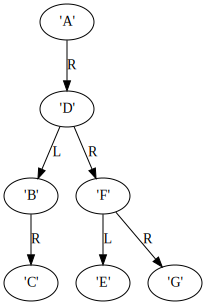

In [2]:
class Node:
    def __init__(self, val):
        self.val = val
        self.left = None
        self.right = None
    
    def to_graphviz(self, g=None):
        if g == None:
            g = Digraph()
            
        # draw self
        g.node(repr(self.val))
    
        for label, child in [("L", self.left), ("R", self.right)]:
            if child != None:
                # draw child, recursively
                child.to_graphviz(g)
                
                # draw edge from self to child
                g.edge(repr(self.val), repr(child.val), label=label)
        return g
    
    def _repr_svg_(self):
        return self.to_graphviz()._repr_image_svg_xml()
    
    def add(self, val):
        if self.val == val:
            return
        elif val < self.val:
            if self.left != None:
                self.left.add(val)
            else:
                self.left = Node(val)
        else:
            if self.right != None:
                self.right.add(val)
            else:
                self.right = Node(val)

    def contains(self, target):
        if target < self.val and self.left != None:
            return self.left.contains(target)
        elif target > self.val and self.right != None:
            return self.right.contains(target)
        return self.val == target
                
tree = Node("A")
tree.add("D")
tree.add("B")
tree.add("F")
tree.add("E")
tree.add("C")
tree.add("G")
tree

In [3]:
tree.contains("G"), tree.contains("Z")

(True, False)

## Part 1: BST-based Dictionary

The above BST (binary search tree) is basically acting like a set.  We can add values and efficiently check whether certain values have already been added.

What if we want to make it act like a dict?  There are a couple things we should do:

1. have both `key` and `val` attributes in `Node`
2. the sort order should be based on `key`, not `val`
3. we should implement `__getitem__` and `__setitem__`

Let's do it:

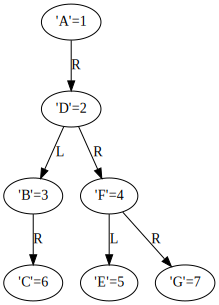

In [4]:
class Node:
    def __init__(self, key, val):
        self.key = key
        self.val = val
        
        self.left = None
        self.right = None
        
    def name(self):
        return repr(self.key) + "=" + repr(self.val)
    
    def to_graphviz(self, g=None):
        if g == None:
            g = Digraph()

        # draw self
        for label, child in [("L", self.left), ("R", self.right)]:
            if child != None:
                child.to_graphviz(g)
                g.edge(self.name(), child.name(), label=label)
        return g
    
    def _repr_svg_(self):
        return self.to_graphviz()._repr_image_svg_xml()
    
    def add(self, key, val):
        if self.key == key:
            self.val = val
        elif key < self.key:
            if self.left != None:
                self.left.add(key, val)
            else:
                self.left = Node(key, val)
        else:
            if self.right != None:
                self.right.add(key, val)
            else:
                self.right = Node(key, val)

    def __getitem__(self, target):
        if target < self.key and self.left != None:
            return self.left[target]
        elif target > self.key and self.right != None:
            return self.right[target]
        assert self.key == target
        return self.val
    
    def __setitem__(self, target, val):
        self.add(target, val)

tree = Node("A", 1)
tree.add("D", 2)
tree.add("B", 3)
tree.add("F", 4)
tree.add("E", 5)
tree.add("C", 6)
tree.add("G", 7)
tree

In [5]:
tree["A"], tree["C"], tree["G"]

(1, 6, 7)

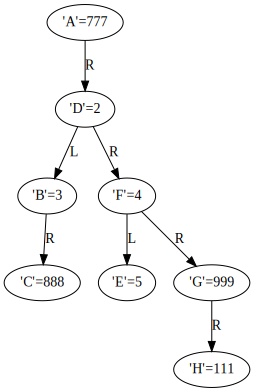

In [6]:
tree["A"] = 777
tree["C"] = 888
tree["G"] = 999
tree["H"] = 111
tree

In [7]:
tree["A"], tree["C"], tree["G"], tree["H"]

(777, 888, 999, 111)

Our BST-based dictionary may have some advantages over the regular `dict`.  Specifically, which features will be easier to add to our version?

1. getting the values corresponding to all keys in some range
2. providing a way to loop over the keys in ascending order
3. finding the key corresponding to a specific value

<details>
<summary>Answers</summary>
(1) yes.  Substrees correspond to ranges of keys, so we can efficiently search for all keys in a range (not possible with a regular dict).<br>
(2) yes.  We would need to write some tricky code with generators, but the data is already arranged in a sorted order.<br>
(3) no.  The same value may appear multiple times anywhere in the tree.  There is no way to efficiently find all nodes with a given value without checking all the nodes.<br>
</details>

## Part 2: Graph Search

Checking whether a tree has a value is an example of a search problem.

What if we want to search a more general graph for a particular value, from a particular starting node?  There are many use cases for this:

1. looking for a route between two cities
2. looking through different move choices in a game (each board state is a node; an edge represents a legal move)
3. cycle detection, perhaps representing incoherent preferences we want to identify (do people claim to like chocolate more than vanilla, vanilla more than strawberry, and strawberry more than chocolate?)

We can force a loop with our Node objects, complicating the search problem.

In [8]:
A = Node("A", 1)
B = Node("B", 2)
A.right = B
B.left = A

In [9]:
def search(node, key):
    if node.key == key:
        return True
    for child in [node.left, node.right]:
        if child != None and search(child, key):
            return True
    return False

# does it work?
search(A, "B")

True

It worked there, but we're going to have a problem if we look for something we can't find.  Searching A will make us search B.  Searching B will make us search A.

This will cause infinite recusion:

In [10]:
try:
    search(A, "Z")
except RecursionError:
    print("I warned you!")

I warned you!


### Graph Search, Done Right

To avoid getting trapped in cycles, we'll need to keep track of which nodes we have visited in our search and make sure we don't visit them more than once.

Let's write a Node class for a general directed graph (each node can have any other node as a child) and a Graph class that can keep graph-wide state, like a set of nodes that have been visited during a recursive search.

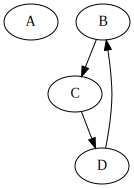

In [11]:
class mygraph:
    def __init__(self):
        self.nodes = {}
    
    def node(self, name):
        self.nodes[name] = Node(self, name)
    
    def edge(self, src, dst):
        for name in [src, dst]:
            if not name in self.nodes:
                self.node(name)
        self.nodes[src].children.append(self.nodes[dst])
        
    def _repr_svg_(self):
        g = Digraph()
        for n in self.nodes:
            g.node(n)
            for child in self.nodes[n].children:
                g.edge(n, child.name)
        return g._repr_image_svg_xml()
    
    def find(self, src, dst):
        self.visited = set()
        return self.nodes[src].find(dst)

class Node:
    def __init__(self, graph, name):
        self.graph = graph
        self.name = name
        self.children = []
        
    def find(self, dst):
        if self.name in self.graph.visited:
            return False
        self.graph.visited.add(self.name)

        if self.name == dst:
            return True
        for child in self.children:
            if child.find(dst):
                return True
        return False

g = mygraph()
g.node("A")
g.edge("B", "C")
g.edge("C", "D")
g.edge("D", "B")
g

In [12]:
g.find("A", "A"), g.find("A", "B"), g.find("B", "D"), g.find("B", "A")

(True, False, True, False)

Challenge: can you modify the find method, so that instead of returning False or True, it returns None (could not find from the starting point) or a list (indicating the path from the src to the dst)?

# Conclusion

There are many ways to search through graph structures to find specific nodes/values.  In this reading, we learned two new techniques:

1. if the graph is a binary search tree, we can efficiently find what we want, without checking each node.  This is because we know an upper/lower bound on a subtree, so we can skip it if it can't contain what we want.
2. if a graph has cycles, it's easy to write search code that results in infinite recursion.  The trick is to keep a set of visited nodes, to make sure we don't keep searching over the same ones infinitely.